In [1]:
%load_ext jupyter_black
%matplotlib inline

In [2]:
import numpyro

numpyro.set_platform("gpu")

In [3]:
import matplotlib.pyplot as plt
import arviz as az

import jax.random as jr
import jax.numpy as jnp
import jax.tree_util as jtu

from jax import nn, lax, vmap

from pymdp.jax.agent import Agent as AIFAgent

from pybefit.inference import (
    run_nuts,
    run_svi,
    default_dict_nuts,
    default_dict_numpyro_svi,
)

from pybefit.inference import NumpyroModel, NumpyroGuide
from pybefit.inference import Normal, NormalPosterior
from pybefit.inference.numpyro.likelihoods import pymdp_likelihood as likelihood

from numpyro.infer.autoguide import AutoNormal, AutoMultivariateNormal
from numpyro.infer import Predictive

from pymdp.utils import random_A_matrix, random_B_matrix
from equinox import Module, field

seed_key = jr.PRNGKey(101)

In [4]:
# define an agent and environment here
batch_size = 10
num_obs = [3, 3]
num_states = [3, 3]
num_controls = [2, 2]
num_blocks = 25
num_timesteps = 5

A_np = random_A_matrix(num_obs=num_obs, num_states=num_states)
B_np = random_B_matrix(num_states=num_states, num_controls=num_controls)
A = jtu.tree_map(lambda x: jnp.broadcast_to(x, (batch_size,) + x.shape), list(A_np))
B = jtu.tree_map(lambda x: jnp.broadcast_to(x, (batch_size,) + x.shape), list(B_np))
C = [jnp.zeros((batch_size, no)) for no in num_obs]
D = [jnp.ones((batch_size, ns)) / ns for ns in num_states]
E = jnp.ones((batch_size, 4)) / 4

pA = jtu.tree_map(lambda x: jnp.broadcast_to(x, (batch_size,) + x.shape), list(A_np))
pB = jtu.tree_map(lambda x: jnp.broadcast_to(x, (batch_size,) + x.shape), list(B_np))


class TestEnv(Module):
    num_obs: int = field(static=True)
    batch_size: int = field(static=True)

    def __init__(self, num_obs, batch_size):
        self.batch_size = batch_size
        self.num_obs = num_obs

    def step(self, key, *args, **kwargs):
        # return a list of random observations for each agent or parallel realization (each entry in batch_dim)
        obs = [jr.randint(key, (self.batch_size,), 0, no) for no in self.num_obs]
        return obs


inf_algo = "fpi"
agents = AIFAgent(
    A, B, C, D, E, pA, pB, use_param_info_gain=True, inference_algo=inf_algo
)
task = TestEnv(num_obs, batch_size)

In [5]:
num_params = 3
num_agents = batch_size
prior = Normal(num_params, num_agents, backend="numpyro")


def transform(z):
    # map z variables to model parameters

    na, np = z.shape

    assert np == 3  # test that we have only 3 parameters

    a = nn.sigmoid(z[..., 0])  # element of the likelihood matrix
    lam = jnp.exp(z[..., 1])  # outcome preference
    d = nn.sigmoid(z[..., 2])  # prior state probability

    C = [
        jnp.zeros((na, 3)),
        jnp.expand_dims(lam, -1) * jnp.array([0.0, 1.0, -1.0]),
    ]

    D = [jnp.ones((na, 3)) / 3, jnp.stack([d, 1 - d, jnp.zeros(na)], -1)]

    # replace first component of A with parameterised likelihood matrix

    a1 = jnp.stack([a, 1 - a, jnp.zeros(na)], -1)

    A[0] = jnp.broadcast_to(
        jnp.expand_dims(a1, (-1, -2)), (na, num_obs[0], *num_states)
    )

    # return the aif agent class
    agent = AIFAgent(
        A,
        B,
        C,
        D,
        E,
        pA,
        pB,
        num_iter=1,
        use_param_info_gain=True,
        inference_algo=inf_algo,
    )
    return agent


key, _key = jr.split(seed_key)
z = jr.normal(_key, shape=(num_agents, num_params)) / 10

transform(z);

In [6]:
from pybefit.inference.methods import default_dict_nuts

opts_task = {
    "task": task,
    "num_blocks": num_blocks,
    "num_trials": num_timesteps,
    "num_agents": num_agents,
}
opts_model = {"prior": {}, "transform": {}, "likelihood": opts_task}

model = NumpyroModel(prior, transform, likelihood, opts=opts_model)

pred = Predictive(model, num_samples=1)
key, _key = jr.split(key)
samples = pred(_key)

In [11]:
# perform inference using no-u-turn sampler
# opts sampling dictionary can be used to specify various parameters
# either for the NUTS kernel or MCMC sampler
measurments = {
    "outcomes": [outcomes[0] for outcomes in samples["outcomes"]],
    "multiactions": samples["multiactions"][0],
}

opts_sampling = default_dict_nuts
opts_sampling["num_warmup"] = 400
opts_sampling["num_samples"] = 100
opts_sampling["sampler_kwargs"] = {"kernel": {}, "mcmc": {"progress_bar": True}}
print(opts_sampling)

mcmc_samples, mcmc = run_nuts(model, measurments, opts=opts_sampling)

{'seed': 0, 'num_samples': 100, 'num_warmup': 400, 'sampler_kwargs': {'kernel': {}, 'mcmc': {'progress_bar': True}}}


sample: 100%|██████████| 500/500 [03:01<00:00,  2.76it/s, 15 steps of size 2.68e-01. acc. prob=0.94] 


In [13]:
measurments = {
    "outcomes": [outcomes[0] for outcomes in samples["outcomes"]],
    "multiactions": samples["multiactions"][0],
}

posterior = NumpyroGuide(NormalPosterior(num_params, num_agents, backend="numpyro"))

# perform inference using stochastic variational inference
opts_svi = default_dict_numpyro_svi | {"iter_steps": 1_000}
print(opts_svi)

svi_samples, svi, results = run_svi(model, posterior, measurments, opts=opts_svi)

{'seed': 0, 'enumerate': False, 'iter_steps': 1000, 'optim': None, 'optim_kwargs': {'learning_rate': 0.001}, 'elbo_kwargs': {'num_particles': 10, 'max_plate_nesting': 1}, 'svi_kwargs': {'progress_bar': True, 'stable_update': True}, 'sample_kwargs': {'num_samples': 100}}


100%|██████████| 1000/1000 [00:37<00:00, 26.51it/s, init loss: 669.2527, avg. loss [951-1000]: 366.4049]


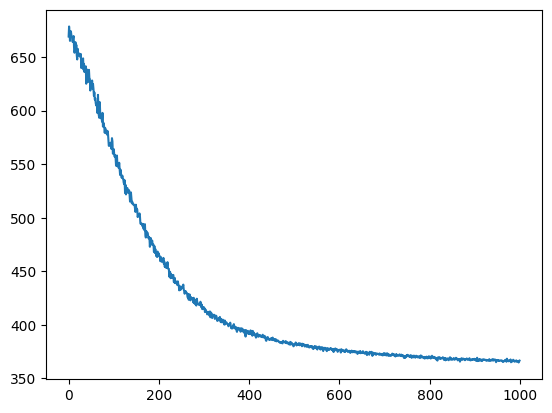

In [15]:
plt.plot(results.losses)

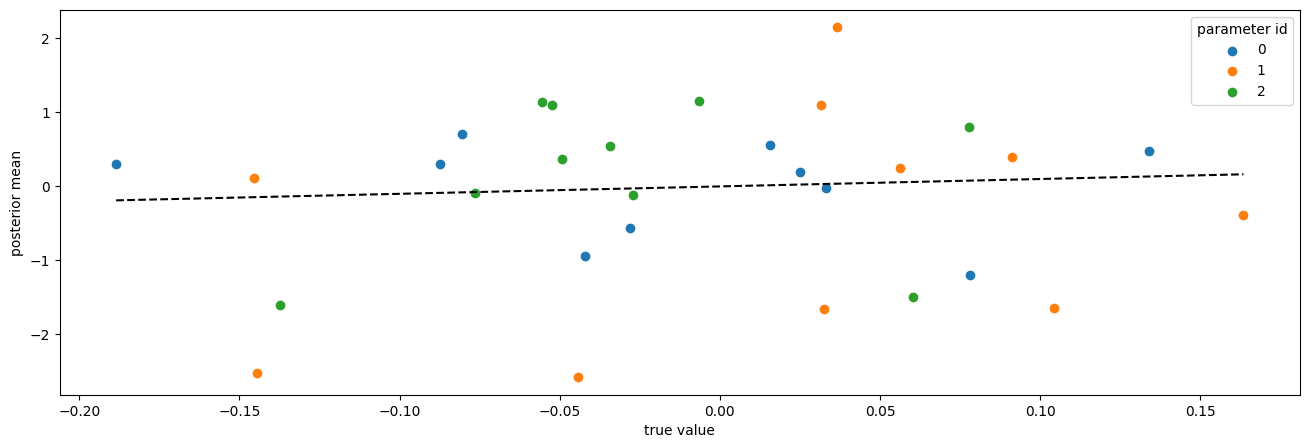

In [16]:
plt.figure(figsize=(16, 5))
for i in range(3):
    plt.scatter(z[:, i], mcmc_samples["z"].mean(0)[:, i], label=i)

plt.plot((z.min(), z.max()), (z.min(), z.max()), "k--")
plt.ylabel("posterior mean")
plt.xlabel("true value")
plt.legend(title="parameter id")

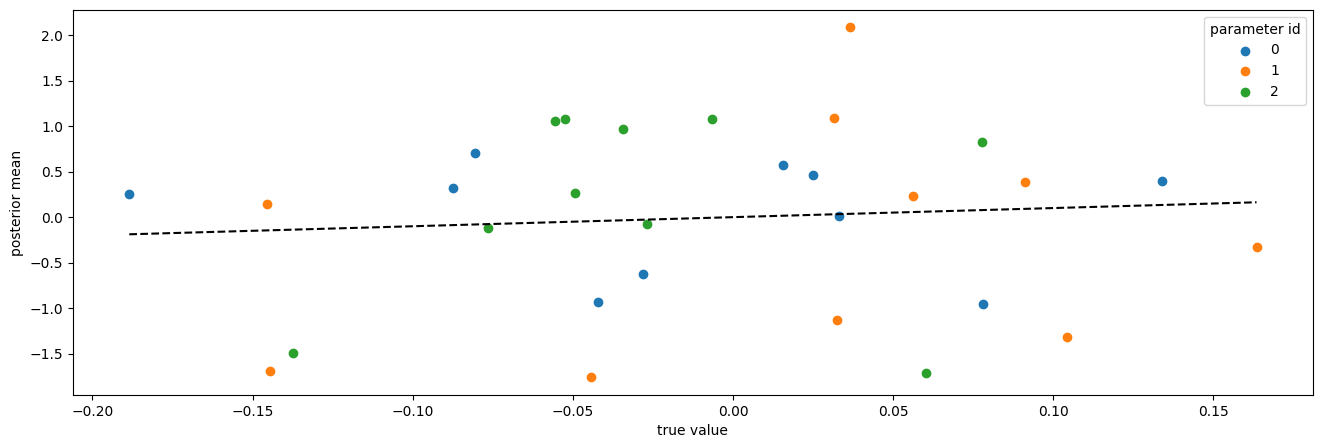

In [17]:
plt.figure(figsize=(16, 5))
for i in range(3):
    plt.scatter(z[:, i], svi_samples["z"].mean(0)[:, i], label=i)

plt.plot((z.min(), z.max()), (z.min(), z.max()), "k--")
plt.ylabel("posterior mean")
plt.xlabel("true value")
plt.legend(title="parameter id")